In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime
import matplotlib.colors as mcolors

import config
config.config(channel='shap',n_steps=8,cfg_bits=[0,1,0,1,1,1,1])

('TCPIP0::169.254.1.214::inst0::INSTR', 'GPIB1::9::INSTR', 'GPIB1::23::INSTR')
Agilent Technologies,B2961A,MY52350174,1.0.1236.9609


    Low terminal: FLO
    Auto output off: 1
    Protection: 1
    Resistance mode: FIX
    Shunt resistance : +2.00000000E+009
    Output current mode: FIX
    Output current level: -2.00000000E-006
    Output voltage range: +2.00000000E+000
    Output status: 1
        
HEWLETT-PACKARD,HP81104A,DE38700607,REV 01.10.00


    Number of pattern positions: +1000
    Source of the trigger: IMM
    Period of the pulse: +1.5000E-08
    Duty cycle of the pulse: +5.0000E+01
    Rise time of the pulse: +3.0000E-09
    Type of pulse: PATTERN
    CH1 data: 20 1's, 980 0's
    CH2 data: as the clock
    STRB data: 20 1's, 980 0's
    Type of the pulse: NRZ
    Internal impedance (source): +5.0000E+01
    External impedance (termination): +1.0000E+02
    High level: +1.2000E+00
    Low level: +0.0000E+00
    Output 1 status: 1
    Output 2 status: 1
        
LECROY,

In [2]:
#print(config.lecroy.query('C1:CRVA? HREL').split(',')[2])
config.ps.write(':SOUR:CURR:LEV 0')

18

In [19]:
channel_name = config.channel_name
gain = config.lemo_gain

df = config.pd.DataFrame()
for i, cl in enumerate(config.current_lev):
	# set current level
	config.ps.write(f':SOUR:CURR:LEV {cl}')
	time.sleep(10)
	# N sample to average and extract std from
	data = pd.DataFrame.from_dict(config.lecroy.get_channel(channel_name='F',n_channel=config.channel_num)['waveforms'][0])
	data['Amplitude (V)'] = data['Amplitude (V)']/gain
	data.insert(0, 'Current level step', i)
	data.insert(1, 'Current level (A)', cl)
	df = pd.concat((df, data))

datetime_str = datetime.strftime(datetime.now(), '%d%m%y_%H%M%S')
df.to_csv(f'G:/My Drive/PHD/FALCON/measures/transient/{channel_name}/{channel_name}_{config.config_bits_str}_nominal_{datetime_str}.tsv', sep='\t')

In [27]:
df = config.pd.read_csv('G:/My Drive/PHD/FALCON/measures/transient/csa/csa_0101011_nominal_030424_153732.tsv',sep='\t')
datetime_str = datetime.strftime(datetime.now(), '%d%m%y_%H%M%S')
channel_name = 'csa'

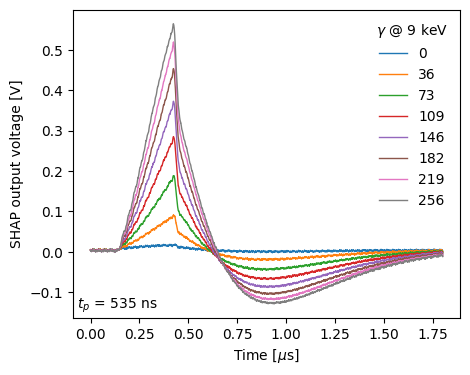

In [20]:
t_s = 0e-9 if config.channel_name == 'csa' else -100e-9
t_e = .7e-6 if config.channel_name == 'csa' else 1.8e-6
sub_df = df[df['Time (s)'].between(t_s, t_e)]

colours = list(mcolors.TABLEAU_COLORS.keys())
fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(5)
for i, cl in enumerate(config.current_lev):
	ax.plot(
		sub_df[sub_df['Current level step'] == i]['Time (s)']*10**6,
		sub_df[sub_df['Current level step'] == i]['Amplitude (V)'],
		'-', linewidth=1, color=colours[i])
ax.set_xlabel('Time [$\\mu$s]')
ax.set_ylabel(f'{channel_name.upper()} output voltage [V]')
ax.legend(np.linspace(0,256,8).astype(int),
		  title=f"$\\gamma$ @ {config.photon_energy} keV",
		  frameon=False)
if channel_name == 'shap':
	ax.text(.01,.01,f'$t_p$ = {config.peaking_time} ns',ha='left',va='bottom',transform=ax.transAxes)
plt.savefig(f'G:/My Drive/PHD/FALCON/measures/transient/{channel_name}/{channel_name}_{config.config_bits_str}_nominal_{datetime_str}.pdf',dpi=300)